# MRI viewer

## Import libraries

In [1]:
!pip install nibabel

In [2]:
%matplotlib notebook

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

## Load/process data

In [3]:
t1 = nib.load("images/t1.nii")  # load the array image

In [4]:
brain = t1.get_fdata(dtype='float64')  # return a memory-map of the underlying numpy array

In [5]:
brain = brain.transpose(1, 0, 2)  # swap x-axis and y-axis

In [6]:
brain.shape  # array length along the x,y,z dimension

(384, 274, 384)

## Implement `viewer()` function

In [7]:
def slicer(data, slice, view):
    '''slice the 3D data along the dimension
       specified by view at position slice
    '''
    slices = {'axial':data[..., slice], 'coronal':data[slice, ...], 'sagittal':data[:, slice, :]}
    return slices[view]

In [8]:
def press(event):
    '''handler for key press event'''
    fig = event.canvas.figure

    if event.key == "up":
        for ax in fig.axes:
            ax.slice = (ax.slice + 1) % ax.n_dim
            new_data = slicer(fig.data, ax.slice, ax.view)
            ax.images[0].set_data(new_data)
            ax.set_title(f"{ax.view} view, slice={ax.slice}")
    
    elif event.key == "down":
        for ax in fig.axes:
            ax.slice = (ax.slice - 1) % ax.n_dim
            new_data = slicer(fig.data, ax.slice, ax.view)
            ax.images[0].set_data(new_data)
            ax.set_title(f"{ax.view} view, slice={ax.slice}")
        
    fig.canvas.draw()
    fig.canvas.flush_events()
    
def scroll(event):
    '''handler for mouse scroll event'''
    fig = event.canvas.figure
    ax = event.inaxes
    n = event.step  # positive for scroll-up, negative for scroll-down
    
    if ax is None: return
    
    if event.button in ("up", "down"):
        ax.slice = (ax.slice + n) % ax.n_dim
        new_data = slicer(fig.data, ax.slice, ax.view)
        ax.images[0].set_data(new_data)
        ax.set_title(f"{ax.view} view, slice={ax.slice}")

    fig.canvas.draw()
    fig.canvas.flush_events()

In [13]:
def viewer(data, slice, view, cmap='viridis'):

    n_dims = {'axial':data.shape[2], 'coronal':data.shape[1], 'sagittal':data.shape[0]}
    
    # create figure    
    fig = plt.figure(figsize=(9, 6.5))
    fig.data = data
    
    # create axes
    if view == 'all':
        spec = fig.add_gridspec(nrows=7, ncols=7)
        
        ax0 = fig.add_subplot(spec[:3, :3])
        ax0.view = 'axial'
        ax0.n_dim = data.shape[2]  # x-y plane
        
        ax1 = fig.add_subplot(spec[:3, 4:])
        ax1.view = 'coronal'
        ax1.n_dim = data.shape[1]  # x-z plane
        
        ax2 = fig.add_subplot(spec[-3:, 2:5])
        ax2.view = 'sagittal'
        ax2.n_dim = data.shape[0]  # y-z plane

        axes = [ax0, ax1, ax2]
        
    else:
        ax0 = fig.add_subplot(111)
        ax0.view = view
        ax0.n_dim = n_dims[view]
        axes = [ax0]
    
    for ax in axes:
        ax.slice = slice
    
    # draw image
    if view == 'all':
        for ax in axes:
            ax.set_title(f"{ax.view} view, slice={ax.slice}")
            ax.imshow(slicer(data, ax.slice, ax.view), cmap=cmap)
    else:
        ax = axes[0]
        ax.set_title(f"{ax.view} view, slice={ax.slice}")
        ax.imshow(slicer(data, ax.slice, ax.view), cmap=cmap)

    # register event handler    
    cid = fig.canvas.mpl_connect('key_press_event', press)
    did = fig.canvas.mpl_connect('scroll_event', scroll)
    
    return cid, did

## Imaging test (including interactive subplot)

<IPython.core.display.Javascript object>


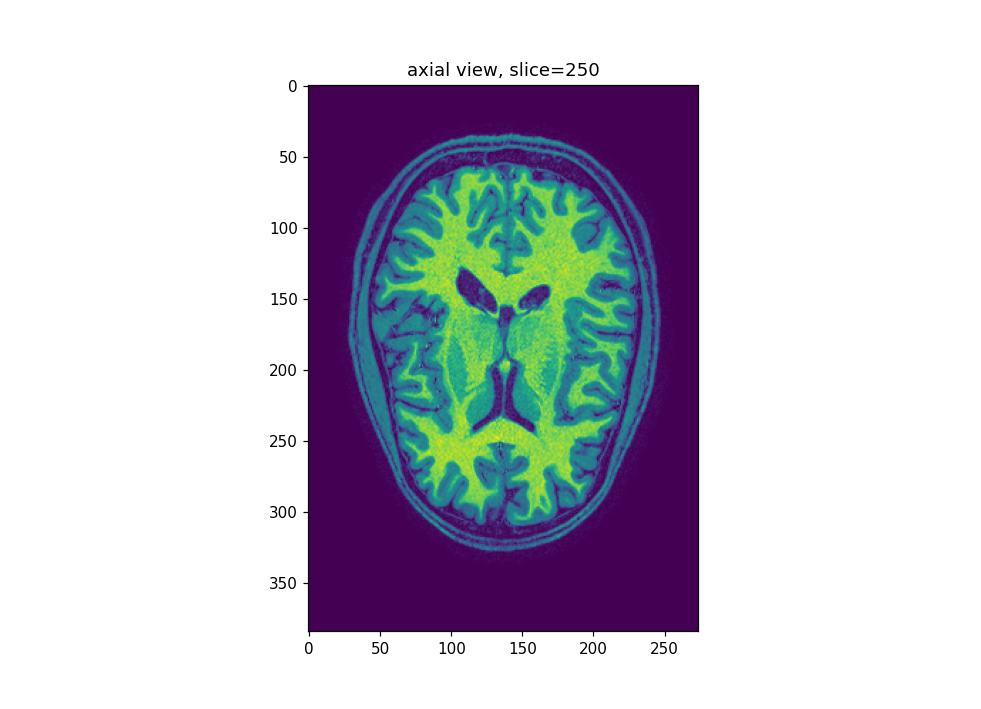

(7, 8)

In [14]:
viewer(brain, slice=250, view='axial')

<IPython.core.display.Javascript object>


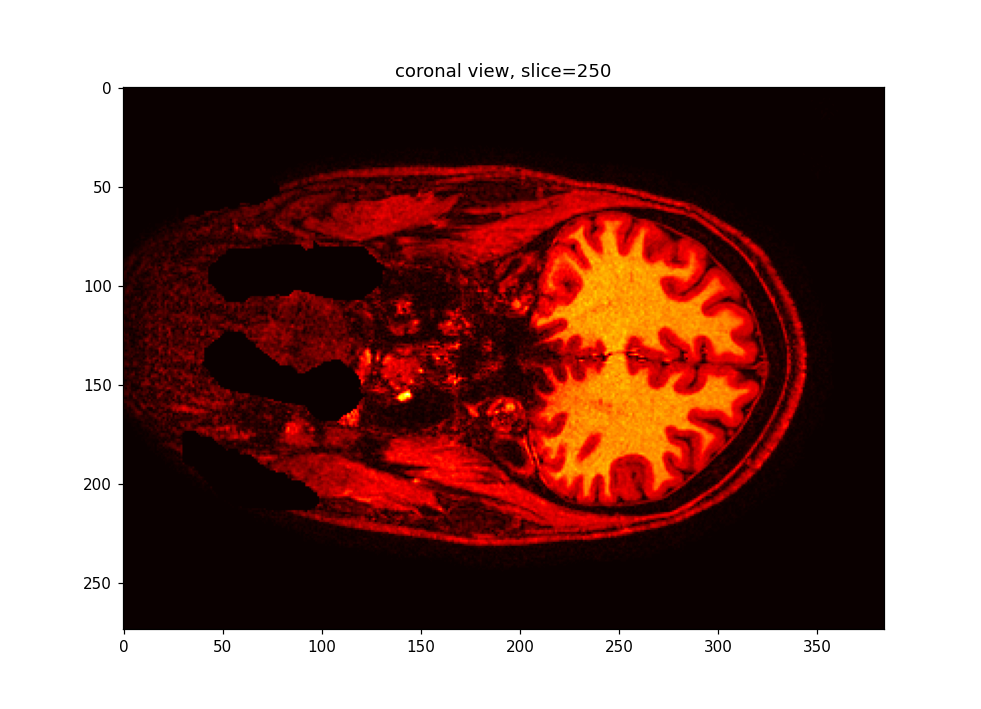

(7, 8)

In [15]:
viewer(brain, slice=250, view='coronal', cmap="hot")

<IPython.core.display.Javascript object>


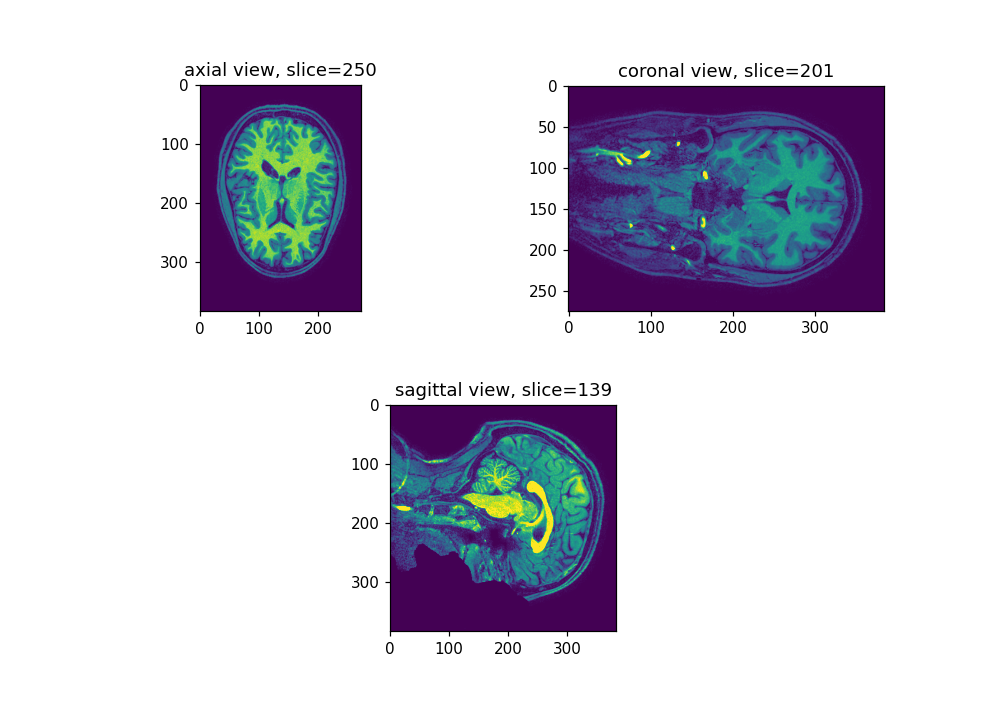

(7, 8)

In [17]:
viewer(brain, slice=250, view='all')

# modalities and frequency-domain filtering

## Part 2a (10%): 2d FFT transform on `t2.nii`

In [18]:
t2 = nib.load("images/t2.nii")  # load the array image

In [19]:
brain = t2.get_fdata(dtype='float64')  # return a memory-map of the underlying numpy array

In [20]:
brain = brain.transpose(1, 0, 2)  # swap x-axis and y-axis

In [21]:
brain.shape  # array length along the x,y,z dimension

(384, 274, 384)

In [22]:
image = brain[...,250]  # an axial slice of the 3D data

Text(0, 0.5, 'frequency')

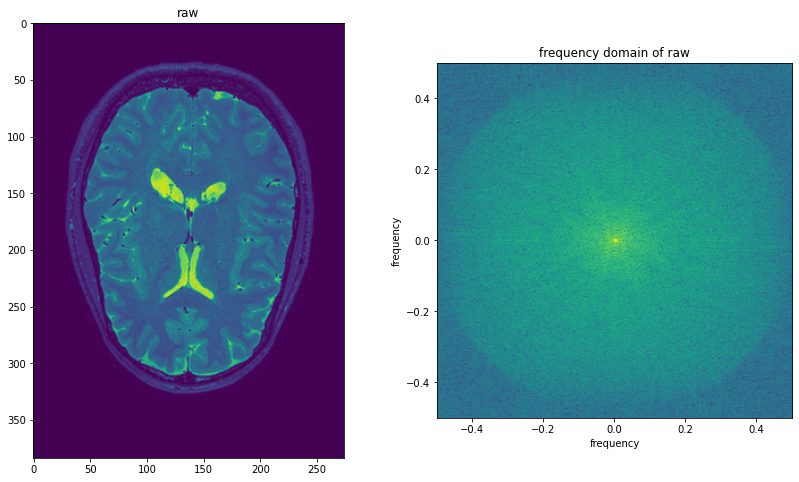

In [24]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))

ax[0].imshow(image)
ax[0].set_title("raw")

f = np.fft.fft2(image)       # 2D Fourier transform of the raw image
fshift = np.fft.fftshift(f)  # shift low-frequency DC components to the center
magnitude = np.abs(fshift)   # compute magnitude

ax[1].imshow(np.log(magnitude), extent=(-.5, .5, -.5, .5))
ax[1].set_title("frequency domain of raw")
ax[1].set_xlabel("frequency")
ax[1].set_ylabel("frequency")

## Part 2b (20%): frequency-domain gaussian filter on `swi.nii`

In [25]:
swi = nib.load("images/swi.nii")  # load the array image

In [26]:
brain = swi.get_fdata(dtype='float64')  # return a memory-map of the underlying numpy array

In [27]:
brain = brain.transpose(1, 0, 2)  # swap x-axis and y-axis

In [28]:
brain.shape  # array length along the x,y,z dimension

(512, 512, 500)

In [29]:
image = brain[...,250]  # an axial slice of the 3D data

Text(0, 0.5, 'frequency')

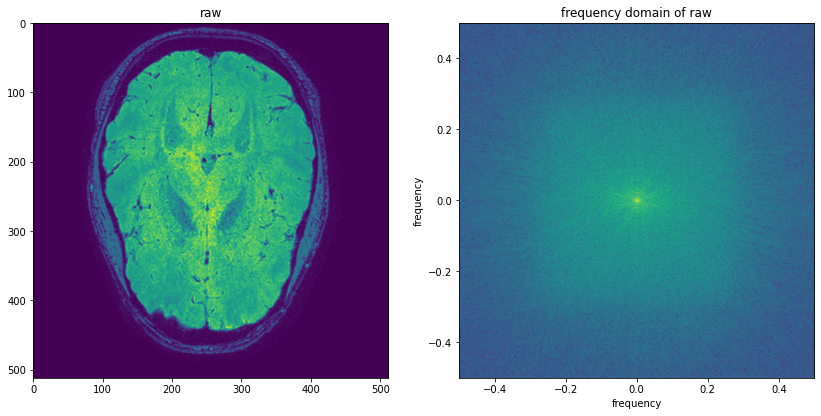

In [30]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))

ax[0].imshow(image)
ax[0].set_title("raw")

f = np.fft.fft2(image)       # 2D Fourier transform of the raw image
fshift = np.fft.fftshift(f)  # shift low-frequency DC components to the center
magnitude = np.abs(fshift)   # compute magnitude

ax[1].imshow(np.log(magnitude), extent=(-.5, .5, -.5, .5))
ax[1].set_title("frequency domain of raw")
ax[1].set_xlabel("frequency")
ax[1].set_ylabel("frequency")

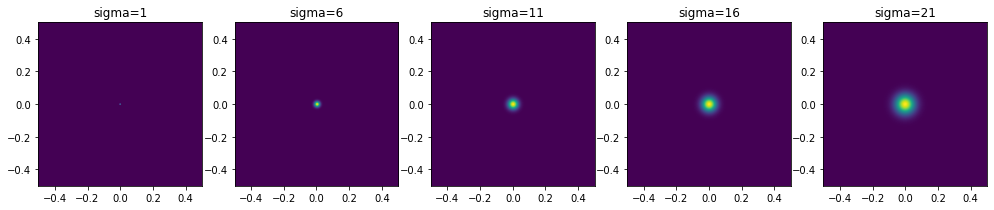

In [31]:
dx = fshift.shape[0]
dy = fshift.shape[1]

X, Y = np.mgrid[0:dx, 0:dy]

x = X - int(dx) // 2
y = Y - int(dy) // 2

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(17, 7))

ax = 0
for sigma in range(1, 25, 5):
    gaussfilt = np.exp(-((x**2 + y**2) / (2 * sigma**2))) / (2 * np.pi * sigma**2)
    axes[ax].imshow(gaussfilt, extent=(-.5, .5, -.5, .5))
    axes[ax].set_title(f"sigma={sigma}")
    ax += 1

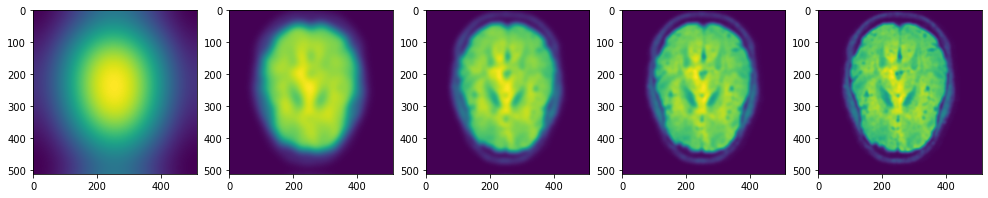

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(17, 7))

ax = 0
for sigma in range(1, 25, 5):
    gaussfilt = np.exp(-((x**2 + y**2) / (2 * sigma**2))) / (2 * np.pi * sigma**2)
    product = fshift * gaussfilt
    img = np.fft.ifft2(np.fft.ifftshift(product))
    axes[ax].imshow(np.abs(img))
    ax += 1

## Part 2c (20%): MRI image filtering on all 5 modalities

In [33]:
t1 = nib.load("images/t1.nii").get_fdata(dtype='float64').transpose(1, 0, 2)
t2 = nib.load("images/t2.nii").get_fdata(dtype='float64').transpose(1, 0, 2)
swi = nib.load("images/swi.nii").get_fdata(dtype='float64').transpose(1, 0, 2)
tof = nib.load("images/tof.nii").get_fdata(dtype='float64').transpose(1, 0, 2)
bold = nib.load("images/bold.nii").get_fdata(dtype='float64').transpose(1, 0, 2)

In [34]:
%matplotlib inline

In [35]:
def build_plot(image, slice):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(17, 10))
    
    # single slice
    raw = image[...,slice]
    ax[0].imshow(raw)
    ax[0].set_title("raw slice")

    # 2D fft
    f = np.fft.fft2(raw)
    fshift = np.fft.fftshift(f)
    mag = np.abs(fshift)
    ax[1].imshow(np.log(mag), extent=(-.5, .5, -.5, .5))
    ax[1].set_title("raw fft")
    
    # create a meshgrid
    dx, dy = fshift.shape
    x, y = np.mgrid[0:dx, 0:dy]
    cx = int(dx) // 2
    cy = int(dy) // 2
    
    # edge enhanced (HPF using a circle mask)
    mask = np.ones_like(fshift, dtype='float64')
    radius = 50
    mask[np.where((x - cx)**2 + (y - cy)**2 <= radius**2)] = 0
    product = fshift * mask
    img = np.fft.ifft2(np.fft.ifftshift(product))
    ax[2].imshow(np.abs(img))
    ax[2].set_title("edge enhanced")
    
    # smoothed (LPF using the previous gaussian filter)
    mx = x - int(dx) // 2
    my = y - int(dy) // 2
    sigma = 21
    gaussfilt = np.exp(-((mx**2 + my**2) / (2 * sigma**2))) / (2 * np.pi * sigma**2)
    product = fshift * gaussfilt
    img = np.fft.ifft2(np.fft.ifftshift(product))
    ax[3].imshow(np.abs(img))
    ax[3].set_title("smoothed")

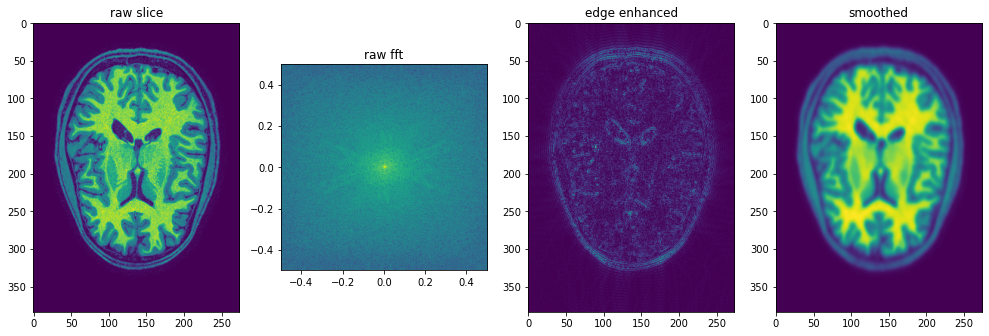

In [36]:
build_plot(t1, 250)

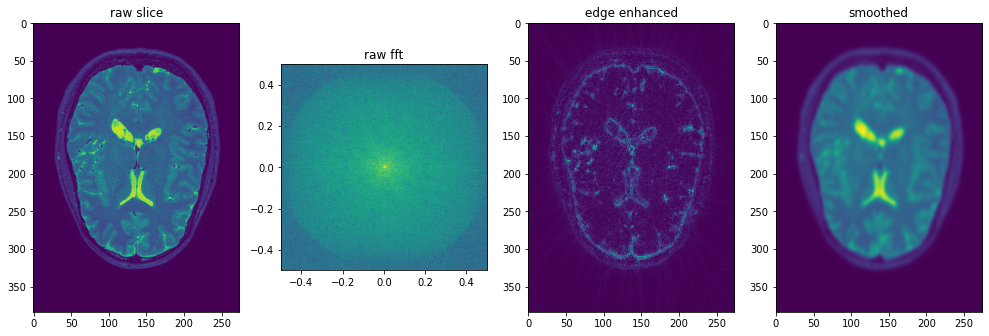

In [37]:
build_plot(t2, 250)

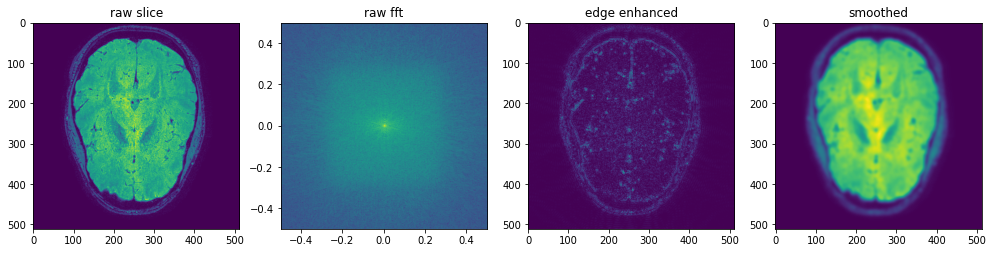

In [38]:
build_plot(swi, 250)

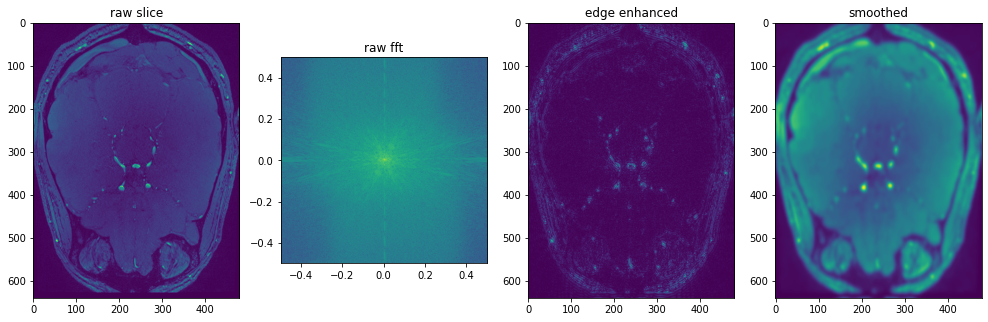

In [39]:
build_plot(tof, 5)

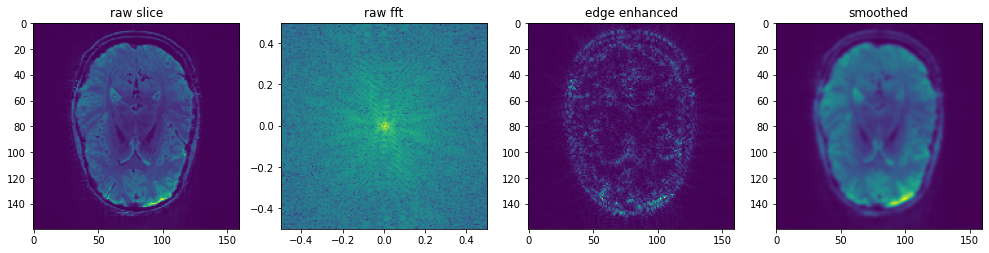

In [40]:
build_plot(bold, 18)

## Bonus question +2.5%: 
Experiment with different filter shapes. What happens if you use a bar or a square, instead of a gaussian smooth?

**Answer**: when I use a square to cover the center of fft image, the corresponding inversely transformed image becomes sharper rather than blurry, so it can be regarded as a naive edge detector. This is because all the lower frequencies components are at the center of the shifted fft image, when they are masked, the high frequencies at the four corners become more observable.

# Reference

- Event handling: https://matplotlib.org/users/event_handling.html
- Colormaps: https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html
- GridSpec: https://matplotlib.org/tutorials/intermediate/gridspec.html